# Anomaly detection using Vision Transformers (stage 1)

Fine-tune Vision Transformers for Anomaly detection.

In [ ]:
%%capture
! pip install transformers
! pip install pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [ ]:
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path

import torch
import pytorch_lightning as pl
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from torchmetrics import Accuracy
from transformers import ViTFeatureExtractor, ViTForImageClassification

In [ ]:
data_dir = Path('Data/Dataset/Ped1')

if data_dir.exists():
    shutil.rmtree(data_dir) #Delete an entire directory tree

categories=["normal","abnormal"]

data_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
for cat_name in categories:
  print(cat_name)


normal
abnormal


In [ ]:
#Google drive operations
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# #Copy dataset folders
!cp -r '/content/drive/MyDrive/Colab Notebooks/ADViTUNet/Dataset/Ped1/normal' '/content/Data/Dataset/Ped1'
!cp -r '/content/drive/MyDrive/Colab Notebooks/ADViTUNet/Dataset/Ped1/abnormal' '/content/Data/Dataset/Ped1'


In [ ]:
data_dir = Path('/content/Data/Dataset/Ped1')

## Init Dataset and Split into Training and Validation Sets


In [ ]:
ds = ImageFolder(data_dir)
indices = torch.randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .30)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

## Show Some Examples

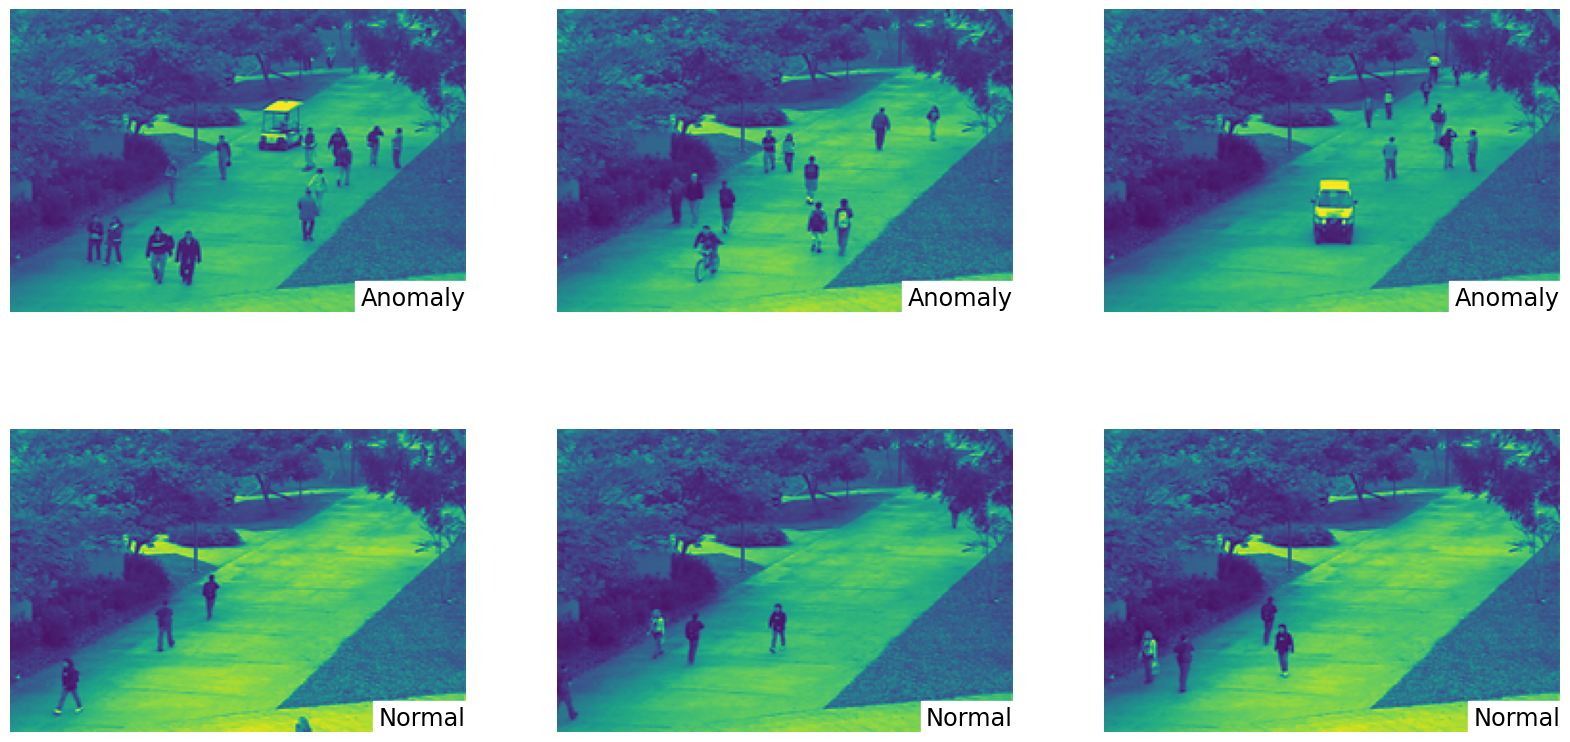

In [ ]:
plt.figure(figsize=(20,10))
num_examples_per_class = 3
i = 1
for class_idx, class_name in enumerate(ds.classes):
    folder = ds.root / class_name
    for image_idx, image_path in enumerate(folder.glob('*')):  #sorted(folder.glob('*'))
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            if(class_name=='abnormal'):
              class_name2 = "Anomaly"
            else:
              class_name2='Normal'

            ax.set_title(
                class_name2,
                size='xx-large',
                pad=5,
                loc='right',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

## Preparing Labels for Our Model's Config

By adding `label2id` + `id2label` to our model's config, we'll get friendlier labels in the inference API.

In [ ]:
label2id = {}
id2label = {}

for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name
    print(id2label[str(i)] , " : " , i)

abnormal  :  0
normal  :  1


## Image Classification Collator

To apply our transforms to frales, we'll use a custom collator class. We'll initialize it using an instance of `ViTFeatureExtractor` and pass the collator instance to `torch.utils.data.DataLoader`'s `collate_fn` kwarg.

In [ ]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

## Init Feature Extractor, Model, Data Loaders


In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(label2id),
    label2id=label2id,
    id2label=id2label
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
len(label2id)  #1000 to 2

2

In [ ]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
for param in model.parameters():
  param.requires_grad=True

In [ ]:
#Update the pretrained ViT head
embedding_dim=768
# set_seeds()

model.heads=torch.nn.Sequential(
            torch.nn.LayerNorm(normalized_shape=embedding_dim),
            torch.nn.Linear(in_features=embedding_dim,
                      out_features=2)
            )

In [ ]:
summary(model=model,input_size=(1,3,224,224),col_names=["input_size","output_size","num_params"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #
ViTForImageClassification                               [1, 3, 224, 224]          [1, 2]                    3,074
├─ViTModel: 1-1                                         [1, 3, 224, 224]          [1, 197, 768]             --
│    └─ViTEmbeddings: 2-1                               [1, 3, 224, 224]          [1, 197, 768]             152,064
│    │    └─ViTPatchEmbeddings: 3-1                     [1, 3, 224, 224]          [1, 196, 768]             590,592
│    │    └─Dropout: 3-2                                [1, 197, 768]             [1, 197, 768]             --
│    └─ViTEncoder: 2-2                                  [1, 197, 768]             [1, 197, 768]             --
│    │    └─ModuleList: 3-3                             --                        --                        85,054,464
│    └─LayerNorm: 2-3                                   [1, 197, 768]             [1, 

In [ ]:
# Create empty results dictionary
results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []
}

# Training
We'll use [PyTorch Lightning](https://pytorchlightning.ai/) to fine-tune our model.

In [ ]:
class Classifier(pl.LightningModule):
    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(task='binary',num_classes=2)

    def training_step(self, batch, batch_idx):
        # print("------ training_step ---------")
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        results["train_loss"].append(outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        results["train_acc"].append(acc)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        # print("------ validation_step ---------")
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        results["val_loss"].append(outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        results["val_acc"].append(acc)
        return outputs.loss

    def configure_optimizers(self):
        print("== lr:",self.hparams.lr)
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
import time
pl.seed_everything(42)    #pytorch_lightning

classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(precision=16, max_epochs=100)

x1=trainer.fit(classifier, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:558: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | BinaryAccuracy            | 0     
-

== lr: 2e-05


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
# classifier
from matplotlib import pyplot as plt

print("Accuracy : ", classifier.val_acc.compute())

Accuracy :  tensor(0.9997)


In [ ]:
# Create empty results dictionary
results2 = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []
}

for i in results['train_loss']:
  # print(i.item())
  results2["train_loss"].append(i.item())

for i in results['val_loss']:
  # print(i.item())
  results2["val_loss"].append(i.item())

for i in results['train_acc']:
  # print(i.item())
  results2["train_acc"].append(i.item())

for i in results['val_acc']:
  # print(i.item())
  results2["val_acc"].append(i.item())

In [ ]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.
    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["val_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["val_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(loss, label="train_loss")
    plt.plot(test_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label="train_accuracy")
    plt.plot(test_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


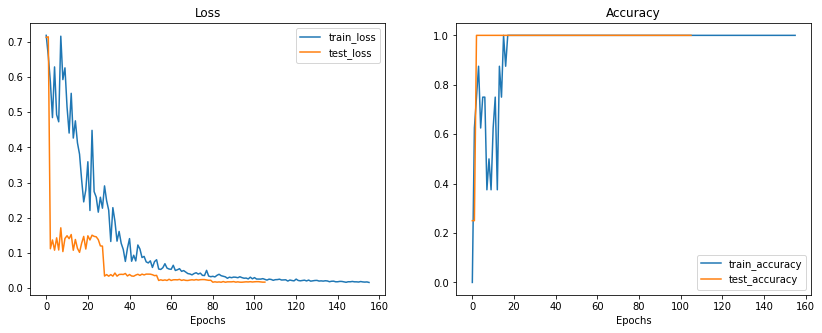

In [ ]:
plot_loss_curves(results2)

In [ ]:
#Save model
model.save_pretrained('modelx')  #pytorch_model.bin and config.json
feature_extractor.save_pretrained('modelx')  #preprocessor_config.json

['modelx/preprocessor_config.json']

In [ ]:
#Save model
model.save_pretrained('/content/models/Model_ped1')
feature_extractor.save_pretrained('/content/models/Model_ped1')

In [ ]:
# Copy model to drive
!cp -r '/content/models/Model_ped1/' '/content/drive/MyDrive/Colab Notebooks/ADViTUNet/Models'

## Check the model

In [ ]:
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

In [ ]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)    #test the model
print('Preds: ', outputs.logits.softmax(1).argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([0, 1, 1, 1, 0, 1, 0, 0])
Labels: tensor([0, 1, 1, 1, 0, 1, 0, 0])
